# 2. Using deep neural networks for regression
## 2.1. How to plan a machine learning problem
* Khi xây dựng một deep neural network, hãy theo dõi các bước sau:
  * Vạch ra vấn đề ta đang muốn giải quyết.
  * Xác định input và output của model.
  * Xác định cost function.
  * Tạo một network.
  * Đào tạo và hiệu chỉnh network.
  
## 2.2. Defining our example problem
* Chúng ta sẽ sử dụng dataset ***wine quality*** [chất lượng rượu] [tại đây](https://archive.ics.uci.edu/ml/datasets/wine+quality) cho các bài toán cho đến khi tôi thông báo ta sẽ sử dụng một dataset mới.
* Có tổng số 4898 observation trong dataset này. Con số này có vẻ khá lơn với bài toán regression cổ điển nhưng lại khá nhỏ cho deep neural network.
* Có 9 đặc điểm hóa học đầu tiên mà ta cần dùng để dự đoán cho target variable (`alcohol`) và chúng đều là các continous variable. Vùng blue square _(bỏ cái `sulphates` đi, vẽ lộn)_ là independent variable và red square là dependent variable:<br>
  ![](./images/02.00.png)

## 2.3. Loading the dataset
* Chúng ta cần load dữ liệu wine quality lên như sau:

In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
TRAIN_DATA = "./data/train/train_data.csv"
VAL_DATA = "./data/val/val_data.csv"
TEST_DATA = "./data/test/test_data.csv"

In [3]:
def load_data():
    '''Load train, val and test datasets from disk.'''
    train = pd.read_csv(TRAIN_DATA)
    val = pd.read_csv(VAL_DATA)
    test = pd.read_csv(TEST_DATA)
    
    '''Using sklearn's StandardScaler to scale our data to 0 mean and unit variance.'''
    scaler = StandardScaler()
    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    test = scaler.transform(test)
    
    '''We will use a dict to keep all this data.'''
    data = dict()
    data['train_y'] = train[:, 10]
    data['train_X'] = train[:, 0:9]
    data['val_y'] = val[:, 10]
    data['val_X'] = val[:, 0:9]
    data['test_y'] = test[:, 10]
    data['test_X'] = test[:, 0:9]
    
    '''Keep the `scaler` so we can unscale prediction in the future.'''
    data['scaler'] = scaler
    
    return data

## 2.4. Defining our cost function
* Đối với các bài toán hồi quy, cost function hay được dùng là **Root Mean Squared Error - RMSE** và **Mean Absolute Error - MAE**. Ở đây chúng ta sẽ dùng MAE, công thức như sau:
  $$\mathrm{MAE} = \dfrac{1}{n} \sum_{j = 1}^n |y_j - \widehat{y_j}|$$

* Bạn cũng có thể sử dụng RMSE như sau:
  $$\mathrm{RMSE} = \sqrt{\dfrac{1}{n} \sum_{j = 1}^n (y_j - \widehat{y_j})^2}$$

* Có thể bạn sẽ bối rối ụa hai cái này làm sao biết nên chọn cái nào:
  * Trong trường hợp lỗi phân bố đều trên training data thì $\mathrm{RMSE} = \mathrm{MAE}$, ví dụ ta có 10 data point và 10 data point này đều có $|y_j - \widehat{y_j}| = 5$.
  * Còn nếu training data có outlier thì $\mathrm{RMSE}$ sẽ **lớn hơn rất nhiều** so với $\mathrm{MAE}$.
* Không có một chuẩn nào đặt ra cho việc lựa chọn cost function, chủ yếu là do cảm nhận của bạn vào dataset. Nhưng về diễn giải, $\mathrm{MAE}$ dễ hiểu hơn so với $\mathrm{RMSE}$.

# 3. Building and MLP in Keras
* Một model của Keras là một tập hợp của các layer và chúng ta cần định nghĩa tập các layer này cho Keras hiểu.
* Keras hiện có hai API để đào tạo model. Trong ví dụ này, chúng ta sẽ sử dụng **Functional API** - nó khá là dài dòng về mặt coding nhưng khả năng tùy biến của nó cao. Hầu hết các pro đều sài Functional API.

* Model MLP của chúng ta sẽ cần:
  * Một input layer.
  * Một hidden layer.
  * Một output layer.

## 3.1. Input layer shape
* Input của chúng ta là một matrix với số dòng là số lượng observation và số cột là số lượng feature của dataset. Vậy input matrix của chúng ta có shape là $\text{số lượng observation} \times 10$.
* Tuy nhiên, chúng ta không cần phải xác định chính xác shape của input matrix. TensorFlow và Keras cho phép chúng ta định nghĩa giá trị `None` cho biến **placeholder** và chúng ta hoàn toàn có thể định nghĩa lại biến placeholder này về sau.

## 3.2. Hidden layer shape
* Hidden layer của chúng ta sẽ có 32 neutron. Tại thời điểm này chúng ta không thể biết chính xác chúng ta cần bao nhiêu neutron cho network vì đây là một hyperparameter và ta cần hiệu chỉnh nó về sau. Việc xác định kiến trúc của một network là một vấn đề mở rộng trong deep learning.
* Vì chúng ta có 32 neutron trong hidden layer, input layer của chúng ta gồm 10 feature nên shape của hidden layer là (10, 32).

## 3.3. Output layer shape
* Output layer của chúng ta sẽ bao gồm duy nhất một neuron, nó nhận vào 32 neutron của hidden layer như là input của nó và tiến hành dự đoán ra một giá trị $\widehat{y}$ duy nhất cho từng data point.
* Vậy model MLP của chúng ta sẽ trông thế này:<br>
  <center>

    ![](./images/02.01.png)

  </center>
  
## 3.4. Neural network architecture
* Bây giờ chúng ta sẽ định nghĩa input và output.

In [4]:
from keras.layers import Input, Dense
from keras.models import Model

In [5]:
def build_network(input_features=None):
    inputs = Input(shape=(input_features,), name='input') # input layer
    x = Dense(32, activation='relu', name='hidden')(inputs) # hidden layer với 32 neuron
    prediction = Dense(1, activation='linear', name='final')(x) # output layer với 1 neuron
    
    model = Model(inputs=inputs, outputs=prediction) # build model với input và output
    model.compile(optimizer='adam', loss='mean_absolute_error') # biên dịch model với adam optimizer và loss mà MAE
    
    return model

* Hãy khám phá hàm trên:
  * Dòng code số 4 ta dùng activation function là `linear`, điều này cũng giống như việc chúng ta không sử dụng bất kì activation function nào, đây là những gì mà chúng ta muốn cho bài toán hồi quy
  * Dòng code số 6, ta định nghĩa đâu là input layer và đâu là output layer cho `Model` object.
  * Dòng code số 7, ta định nghĩa Adam optimizer cho `optimizer` và MAE cho `loss` function.
* Bây giờ chúng ta có thể gọi hàm `build_model()` để xây dựng một neural network như sau:

In [6]:
model = build_network(input_features=10)

* Giả sử bây giờ ta muốn hiệu chỉnh các hyperparameter của Adam optimizer thì ta có thể làm như sau:

In [7]:
from keras.optimizers import adam_v2

def build_network_with_adam_hyperparams(input_features=None):
    inputs = Input(shape=(input_features,), name='input') # input layer
    x = Dense(32, activation='relu', name='hidden')(inputs) # hidden layer với 32 neuron
    prediction = Dense(1, activation='linear', name='final')(x) # output layer với 1 neuron
    
    adam_optimizer = adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
    
    model = Model(inputs=inputs, outputs=prediction) # build model với input và output
    model.compile(optimizer=adam_optimizer, loss='mean_absolute_error') # biên dịch model với adam optimizer và loss mà MAE
    
    return model

## 3.5. Training the Keras model
* Bây giờ chúng ta sẽ load data lên bằng hàm `load_data()`.

In [16]:
data = load_data()

* Bây giờ chúng ta sẽ lấy số feature từ tập training data.

In [19]:
input_features = data['train_X'].shape[1]

print("Có {} features bên trong training fata.".format(input_features))

Có 9 features bên trong training fata.


* Bây giờ sẽ build model.

In [20]:
'''Load model architecture'''
model = build_network(input_features=input_features)

'''Fit model with training data and hyperparameters'''
model.fit(x=data['train_X'], y=data['train_y'],
          batch_size=32, epochs=200, verbose=1, 
          validation_data=(data['val_X'], data['val_y']))

Epoch 1/200
123/123 [==============================] - 2s 3ms/step - loss: 0.6212 - val_loss: 0.4836
Epoch 2/200
123/123 [==============================] - 0s 1ms/step - loss: 0.4235 - val_loss: 0.3615
Epoch 3/200
123/123 [==============================] - 0s 1ms/step - loss: 0.3336 - val_loss: 0.2890
Epoch 4/200
123/123 [==============================] - 0s 2ms/step - loss: 0.2789 - val_loss: 0.2607
Epoch 5/200
123/123 [==============================] - 0s 1ms/step - loss: 0.2495 - val_loss: 0.2456
Epoch 6/200
123/123 [==============================] - 0s 1ms/step - loss: 0.2346 - val_loss: 0.2460
Epoch 7/200
123/123 [==============================] - 0s 1ms/step - loss: 0.2292 - val_loss: 0.2410
Epoch 8/200
123/123 [==============================] - 0s 1ms/step - loss: 0.2240 - val_loss: 0.2367
Epoch 9/200
123/123 [==============================] - 0s 1ms/step - loss: 0.2216 - val_loss: 0.2384
Epoch 10/200
123/123 [==============================] - 0s 1ms/step - loss: 0.2191 - val_lo

* Bây giờ, hãy cũng điểm qua một vài đối số quan trọng của hàm Keras's `fit()`, cụ thể như sau:
  * `batch_size`: Keras mặc định tham số này có giá trị là 32. Batch size số observation mà bạn muốn model lấy cho một lần đào tạo network. Ngoài ra có thể kham thảo thêm [bài viết này](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network) để hiểu rõ hơn về batch size, cũng như ưu điểm và nhược điểm của nó.
  * `epochs`: là số lần mà model được nhìn thấy toàn bộ training data. Có thể tìm hiểu rõ hơn [tại đây](https://www.baeldung.com/cs/epoch-neural-networks).
  * `validation_data`: ở đây, chúng ta chỉ cần cho model biết đâu là val data. Vào cuối mỗi epoch, Keras sẽ thực hiện kiểm tra model trên val data và đưa ra kết quả bằng loss function (cộng thêm các độ đo khác mà ta chỉ định).
    * Ngoài ra, chúng ta có thể sử dụng tham số `validation_split` bằng một giá trị float dùng để chỉ định phần trăm từ tập training data mà ta muốn tách ra để làm val data cho model.
  * `verbose`: tham số này không liên quan gì đến quá trình đào tạo network, nó chỉ đơn giản là dùng để hiển thị các thông tin trong quá trình đào tạo model. Nếu ta đặt là 1 nó sẽ xuất ra một thanh tiến trình hiển thị trạng thái đào tạo model qua từng epoch, đồng thời nó xuất ra cả thông tin về thời gian đào tạo qua từng epoch, giá trị của loss function. Nếu đặt bằng 2 thì nó sẽ chỉ xuất ra các giá trị loss function. Còn nếu đặt là 0 thì nó không xuất gì hết.
* Ta có thể in ra thông tin tổng kết của model như sau:

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 9)]               0         
_________________________________________________________________
hidden (Dense)               (None, 32)                320       
_________________________________________________________________
final (Dense)                (None, 1)                 33        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


* ...
  * Ở đây, cột `Param #` cho ta biết số lượng learnable parameters của từng layer.
  * `Output Shape` cho biết hình dạng output đầu ra của từng layer. 
* Bây giờ, chúng ta sẽ lưu lại model để có thể tái sử dụng vào dự đoán sau này.

In [22]:
model.save("./models/wine_quality/regression_model")

INFO:tensorflow:Assets written to: ./models/wine_quality/regression_model/assets


* Chúng ta load lại model sau này để sử dụng bằng hàm sau:
  ~~~python
  model = model.load("./models/wine_quality/regression_model")
  ~~~

## 3.6. Measuring the performance of our model
* Chúng ta đã đào tạo xong model của mình, chúng ta có thể dùng model để dự đoán như sau:

In [32]:
test_pred = model.predict(data['test_X'])
df = pd.DataFrame({
    "Test Actual Value": data['test_y'],
    "Test Prediction Value": test_pred.ravel()
})

print("Shape: {}".format(df.shape))
df.head(10)

Shape: (490, 2)


,Test Actual Value,Test Prediction Value
0,-0.092478,-0.343986
1,0.315172,0.044300
2,-1.560018,-1.132815
3,0.396702,0.591061
4,2.842601,2.280361
5,-0.092478,0.128674
6,0.559762,0.647970
7,0.885881,0.721770
8,-0.989308,-1.117429
9,-0.663188,-0.841912


* Ta cũng có thể evaluation model như sau:

In [33]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(data["train_y"], model.predict(data["train_X"]))
mae_val = mean_absolute_error(data["val_y"], model.predict(data["val_X"]))
mae_test = mean_absolute_error(data["test_y"], model.predict(data["test_X"]))

print("Model Train MAE: {}".format(mae_train))
print("Model Val MAE: {}".format(mae_val))
print("Model Test MAE: {}".format(mae_test))

Model Train MAE: 0.19497187468041116
Model Val MAE: 0.2112075187495282
Model Test MAE: 0.21319993850457947


> **Nhận xét**
> * Ta thấy rằng, MAE trên training data và test data lần lượt là 0.19 và 0.21, điều này chứng tỏ model ta không bị overfitting vì hai giá trị lỗi này khá gần nhau.
> * Trong trường hợp MAE trên training data quá nhỏ nhưng trên test data thì lại quá lờn thì overfitting xảy ra. Tức lúc này model của ta có thể bị bias error, khi điều này xảy ra, chúng ta có thể thử thêm nhiều layer hơn, tăng số lượng neuron, hoặc cả hai. Chúng ta sẽ tìm hiểu kĩ hơn điều này sau.

* Ta cũng có thể trực quan hóa sự khác biệt giữa actual value và prediction value trên test data như sau

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

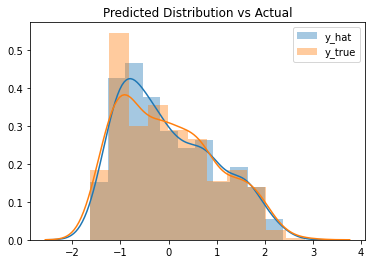

In [36]:
y_hat = model.predict(data['test_X'])

plt.title("Predicted Distribution vs Actual")
sns.distplot(y_hat.flatten(), label='y_hat')
sns.distplot(data['test_y'], label='y_true')
plt.legend();

* Chúng ta có thể lưu hành trên lại nếu thêm dòng code này vào ngay sau `plt.legend()`:
  ```python
  plt.savefig("pred_dist.jpg")
  ```